In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Reinforcement Learning
## Markov Decision Process

- Terminologies
    - $S$ : set of states
    - $A$ : set of actions
    - $P_{\{s,a\}}(s')$ : state transition probabilities (sum up 0)
    - $\pi(s)$ : policy for the state → $\pi: S \mapsto A$
    - $\gamma$ : discount factor (0, 1) (e.g. 0.99)
    - $R(s)$ : reward Function

- Operation: $s_0$ → choose action $a_0$ → get to $s_1 \sim P_{s_0a_0}$ → choose action $a_1$ …

- Total payoff: $R(s_0) + \gamma R(s_1) + \gamma^2 R(s_2)  \cdots$

- GOAL : choose actions over time to maximize Expectation value of total payoff

- policy: when in state s, take action $\pi(s)$

**How to compute optimal policy?**

Define $V^\pi, V^*, \pi^*$

- For a policy $\pi$ , $V^\pi:  s\mapsto ℝ$  is s.t. $V^\pi(s)$  is the expected total payoff for starting state in s and executing $\pi$
$V^\pi(s) = E[R(s_0) + \gamma R(s_1) + \gamma^2 R(s_2)  \cdots | \pi, s_0 = s]$

- $V^\pi$ : Value function for policy $\pi$

- Bellman’s equations
    $$
    V^\pi(s) = R(s)+ \gamma\sum_{s'}P_{s\pi(s)}V^\pi(s')
    $$
    ( R(s) is called immediate reward)
    (use linear solver)
    
- $V^*$  is the optimal value function (i.e.  $V^*(s) = \max_\pi V^\pi(s)$)
  - $V^{*}(s) = R(s)+ \max_a \gamma\sum_{s'}P_{sa}(s')V^*(s')$
  - $\pi^*(s) = \text{argmax}_a \sum_{s'}P_{sa}(s')V^*(s')$

**Strategy to find $\pi^*$**

Value iteration

1. Initialize $V(s) := 0$ for every s
2. for every s, update:  (synchronized update → calculate vector simultaneously)
$V(s) := R(s)+ \max_a \gamma\sum_{s'}P_{sa}(s')V(s') = R(s)+ \max_a \gamma E_{s'\sim P_{sa}}[V(s')]$
3. V to converge V star ( higher discount factor, faster converging)
4. use equation to find pi star

Policy iteration

1. Initilaize policy randomly
2. Repeat:
- Set $V := V^\pi$ (i.e solve bellman’s eqations to get $V^\pi$) (linear solver)
- Set $\pi(s) := \text{argmax}_a \sum_{s'}P_{sa}(s')V(s')$


+)
When don’t know $P_{sa}$

$P_{sa}(s')$ = # times took action “a” in state s and got to s’/ # times took action “a” in state s

(or 1/|s| if above is 0/0)

++) Exploration vs Exploitation

→ a. take actions → 0.9 chance wrt π, 0.1 chance randomly ($\epsilon$-greedy)

In [ ]:
class Agent():

    def __init__(self, environment, disc = 0.8):
        self.env = environment
        self.disc = disc
        self.state_size = self.env.size
        self.action_size = self.env.action_size

    # def get_action(self, state, epsilon):
    #     if np.random.rand() > epsilon:
    #         return np.max(self.policy[state])
    #     else
    #         return np.random.choice(4)
    #     return np.max(self.policy[state])

    def get_action_sum(self, value):
        states = np.arange(self.state_size)
        dest = states + self.env.move.reshape(-1, 1)
        #edge case
        dest[0] = np.where(states % self.env.sizex == self.env.sizex - 1, states, dest[0])
        dest[1] = np.where(states % self.env.sizex == 0, states, dest[1])
        dest[2] = np.where(states >= self.state_size - self.env.sizex, states, dest[2])
        dest[3] = np.where(states < self.env.sizex, states, dest[3])

        dest_val = value[dest]

        sum_arr = self.env.actions_prob @ dest_val
        return sum_arr

    def train_valueiter(self, epoch, epsilon = 0.01):
        #value iteration
        value = np.zeros(self.state_size)
        for i in range(epoch):
            imm_reward = self.env.reward
            actionsum = self.get_action_sum(value)
            actionmax = self.disc * np.max(actionsum, axis = 0)
            new_value = imm_reward + actionmax
            new_value[self.env.terminal] = self.env.reward[self.env.terminal]

            if (np.all(np.abs(new_value - value) < epsilon)):
                print(f"Converged at epoch {i}")
                break
            value = new_value

        #set pi star
        actionsum = self.get_action_sum(value)
        self.pi_star = np.argmax(actionsum, axis = 0)

        print(value.reshape((self.env.sizey,self.env.sizex)))
        print(self.pi_star.reshape((self.env.sizey,self.env.sizex)))


    def train_policyiter(self, epoch, epsilon = 0.01):
        policy = np.random.randint(0, 4, size = self.state_size)
        value = np.zeros(self.state_size)
        for i in range(epoch):

            #Policy Evaluation
            while True:
                imm_reward = self.env.reward
                actionsum = self.get_action_sum(value)
                masked = actionsum[policy, np.arange(self.state_size)]
                new_value = imm_reward + self.disc * masked
                new_value[self.env.terminal] = self.env.reward[self.env.terminal]
                if np.all(np.abs(new_value - value) < epsilon):
                    break
                value = new_value.copy()

            #Policy Improvement
            actionsum = self.get_action_sum(value)
            new_policy = np.argmax(actionsum, axis = 0)

            if (np.all(new_policy == policy)):
                print(f"Converged at epoch {i}")
                break
            policy = new_policy

        self.pi_star = new_policy
        print(value.reshape((self.env.sizey,self.env.sizex)))
        print(self.pi_star.reshape((self.env.sizey,self.env.sizex)))



class environment():
    reward = np.array([0 , 0, 0, 0, 0, 0,-1,-1,-1,-1,
                       0 , 0, 0, 0, 0, 0, 0, 0, 0, 0,
                       -1,-10,-1,-1, 0, 10, 0, 0, 0,0,
                       -1,-1,-10,-1, 0, 0, 0, 0, 0, 0,
                       0 , 0, 0, 0, 0, 0, 0, 0, 0, 0,])
    terminal = 49
    start = 0
    size = 50
    sizey = 5
    sizex = 10
    action_size = 4
    move = np.array([+1,  -1, +1*sizex, -1*sizex])
    actions_prob = np.array([[0.70,   0,0.15,0.15],
                            [   0,0.75,0.15,0.15],
                            [0.15,0.15,0.75,   0],
                            [0.15,0.15,   0,0.75]])

    def __init__(self, a):
        pass

agent = Agent(environment)
agent.train_policyiter(100)
agent.train_valueiter(100)


Converged at epoch 4
[[ 3.35143238  4.6645147   6.47162803  8.60574514 11.29691358 14.09884232
  10.80098506  8.11315127  5.97882786  4.44250154]
 [ 2.82716697  4.01247091  7.30092161 10.4014623  14.28783124 19.08200835
  15.22649226 11.83518559  9.12082351  6.98694798]
 [-0.05945603 -6.18670706  5.83943983 11.39917761 17.91980769 25.90105951
  19.1977227  14.38384048 10.86438112  8.18080717]
 [ 0.34349116  0.52493507 -3.4992866   9.31477462 14.17500416 19.07154786
  15.25213224 12.05930333  9.49935824  6.872827  ]
 [ 2.06584634  3.17314641  4.87420334  8.40975744 11.22173852 14.23237078
  12.04112795  9.8525493   8.01267133  0.        ]]
[[0 0 0 0 2 2 2 2 2 2]
 [3 3 0 0 2 2 2 1 1 1]
 [3 0 0 0 0 3 1 1 1 1]
 [2 2 0 0 0 3 3 1 1 3]
 [0 0 0 0 3 3 3 1 1 1]]
Converged at epoch 37
[[ 3.33873563  4.64994051  6.45407303  8.59065414 11.27677984 14.08319317
  10.7792342   8.09611833  5.95574508  4.42223538]
 [ 2.81867311  3.99764798  7.28694392 10.38264137 14.27312498 19.06094009
  15.21071555 11

##Continuous State MDP
state: $[x, y, \theta, \dot x, \dot y, \dot \theta …]$
### Discretization
→ just divide space, make it discrete. works well with small problem
Problems

- Naive representation for $V^*$
- Curses of dimensionality
    
    $s=ℝ^n$, and discretize each dimension into k values, get $k^n$ discrete states.
    
    Good for 2 ~ 3 Dimensional space, 4 ~ 6 works with some technic

### Fitted Value Iteration
- Express $V(s)$ as Linear Regression or Neural Network

- (Linear Regression)
$V(s)  = \theta^T\phi(s)$,  $\phi(s) = [x, \dot{x}, x\dot{x} \dots]$

- Making Target Value, Then Fitting the model

1. Dataset ${s^{(1)}, s^{(2)}, \dots, s^{(m)}}$

2. Target Generation
$$y^{(i)} = \max_{a \in A} \left[ R(s^{(i)}) + \gamma \sum_{s'} P(s' | s^{(i)}, a) \hat{V}(s'; \theta_{\text{old}}) \right]$$

3. Fitting Model (Gradient Descent)
$$\theta_{\text{new}} = \arg \min_{\theta} \frac{1}{m} \sum_{i=1}^{m} \left( \hat{V}(s^{(i)}; \theta) - y^{(i)} \right)^2$$




In [34]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
linear = lambda x: x
ReLU = lambda x: np.maximum(0,x)

def one_hot_encode(Y, num_classes):
    N = Y.shape[0]
    one_hot_Y = np.zeros((N, num_classes))
    # Ensure Y is flattened to 1D for advanced indexing
    one_hot_Y[np.arange(N), Y.flatten()] = 1
    return one_hot_Y

class Network:
    def __init__(self, architecture: list):
        self.architecture = architecture
        self.layers = []
        self.activations = []
        length = len(architecture)
        for i in range(length-2):
            self.layers.append(Dense(architecture[i], architecture[i+1], ReLU, i))

        self.layers.append(Dense(architecture[-2], architecture[-1], linear, length-1))
        #self.layers.append(OutSoftmax())

    #x: np.array[feature, 1]
    def propagation(self, x):
        prev = x
        for layer in self.layers:
            prev = layer.forward(prev)
        return prev

    def back_propagation(self, x, y_hat, y_res):
        dloss = (y_res - y_hat) / y_hat.shape[0]

        for layer in reversed(self.layers):
            dloss = layer.backward(dloss, self.alpha)

    def learn_network(self, x, y_true, epoch = 100, alpha=0.01):
        self.alpha = alpha
        num_classes = self.architecture[-1]

        for cnt in range(epoch):
            y_res = self.propagation(x)
            self.back_propagation(x, y_true, y_res)

class Layer:
    def __init__(self):
        self.params = {}
        self.grads = {}

    def forward(self, x):
        raise NotImplementedError

    def backward(self, dout):
        raise NotImplementedError

class Dense(Layer):
    def __init__(self, input_size, output_size, activation, layerindex):
        super().__init__()
        std_dev = np.sqrt(2 / input_size)
        self.params['w'] = np.random.randn(input_size, output_size) * std_dev
        self.params['b'] = np.zeros((1, output_size))
        self.activation = activation
        self.layerindex = layerindex

    def forward(self, x):
        self.x = x
        out = x @ self.params['w']+ np.tile(self.params['b'],(x.shape[0],1))
        out = self.activation(out)
        self.out = out
        return out

    def backward(self, dout, alpha):
        w = self.params['w']
        if self.activation == sigmoid:
            dZ = dout * (self.out * (1 - self.out))
        elif self.activation == ReLU:
            dZ = dout * (self.out > 0)
        else: # linear
            dZ = dout

        dw = self.x.T @ dZ
        db = np.sum(dZ, axis=0)
        dx = dZ @ w.T

        self.params['w'] -= alpha * dw
        self.params['b'] -= alpha * db
        #print(f"Layer ({self.layerindex}) W: {self.params['w'] }, b: {self.params['b']}", end="")
        return dx

class OutSoftmax(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        out = (lambda e: np.exp(e))(x)
        sums = np.sum(out, axis = 1)
        sums = sums.reshape(-1,1)
        sums = sums.repeat(out.shape[1], axis=1)
        out = out / sums
        self.out = out
        return out

    def backward(self, y_hat, alpha):
        return y_hat


In [74]:
class ContinuousEnv:
    def __init__(self):
        # 상태 차원: [카트 위치, 카트 속도, 막대기 각도, 막대기 각속도]
        self.state_dim = 4
        self.action_size = 2 # 0: 왼쪽, 1: 오른쪽

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5 # 막대기 길이의 절반
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # 타임스텝 (dt)

    def transition(self, state, action):
        """
        Input:
            state: [x, x_dot, theta, theta_dot]
            action: 0 or 1
        Output:
            next_state, reward
        """
        state = state.flatten()
        x, x_dot, theta, theta_dot = state

        # 1. 행동에 따른 힘 결정
        force = self.force_mag if action == 1 else -self.force_mag

        # 2. 물리 법칙 계산 (Simplified CartPole Dynamics)
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        theta_acc = (self.gravity * sintheta - costheta * temp) / \
                    (self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass))
        x_acc = temp - self.polemass_length * theta_acc * costheta / self.total_mass

        # 3. 상태 업데이트 (Euler Integration)
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * x_acc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * theta_acc

        next_state = np.array([x, x_dot, theta, theta_dot])
        next_state = np.clip(next_state, -5, 5)

        # 4. 보상 설계 (Reward Design)
        Q = np.array([1, 1, 100, 10]) # 각 상태에 대한 가중치
        #print(next_state, Q)
        reward = - ( (next_state**2) @ Q )
        if np.abs(theta) > 0.5: # 약 30도 이상
            reward -= 100

        return next_state, reward

class FVIAgent():
    def __init__(self, environment):
        self.env = environment
        self.model = Network([self.env.state_dim , 64, 64, 1])
        self.disc = 0.99

    def train(self, num_samples=1000, epoch=50):
        # 1.sample data
        states = np.random.uniform(-1, 1, (num_samples, self.env.state_dim))

        for it in range(epoch):
            targets = []

            # 2.Calculate Target
            for s in states:
                v_max, _ = self.getAction(s)
                targets.append(v_max)

            y_train = np.array(targets).reshape(-1, 1)

            y_train = np.clip(y_train, -100, 100)
            # 3. Fitting
            self.model.learn_network(states, y_train, epoch=50, alpha=0.01)

    def getAction(self, s):
        q_values = []
        for a in range(self.env.action_size):
            next_s, reward = self.env.transition(s, a)

            v_next = self.model.propagation(next_s.reshape(1, -1))
            q_values.append(reward + self.disc * v_next)

        return np.max(q_values), np.argmax(q_values)



agent = FVIAgent(ContinuousEnv())
agent.train()

Step 0 | State: [0.  0.  0.1 0. ] | Action: 1 | V: -100.5249
Step 1 | State: [ 0.          0.19355619  0.1        -0.2595328 ] | Action: 0 | V: -99.7524
Step 2 | State: [ 0.00387112 -0.00284058  0.09480934  0.06294163] | Action: 1 | V: -100.1668
Step 3 | State: [ 0.00381431  0.19080319  0.09606818 -0.19838732] | Action: 0 | V: -99.8135
Step 4 | State: [ 0.00763038 -0.00555219  0.09210043  0.12298827] | Action: 1 | V: -99.9375
Step 5 | State: [ 0.00751933  0.18813785  0.0945602  -0.13927616] | Action: 0 | V: -99.9864
Step 6 | State: [ 0.01128209 -0.0082023   0.09177467  0.18167763] | Action: 1 | V: -99.8238
Step 7 | State: [ 0.01111804  0.18549475  0.09540823 -0.08070135] | Action: 0 | V: -100.2723
Step 8 | State: [ 0.01482794 -0.01085621  0.0937942   0.24049311] | Action: 1 | V: -99.8243
Step 9 | State: [ 0.01461081  0.18280945  0.09860406 -0.02119344] | Action: 0 | V: -100.6837
Step 10 | State: [ 0.018267   -0.01357817  0.09818019  0.30089972] | Action: 1 | V: -99.9489
Step 11 | State

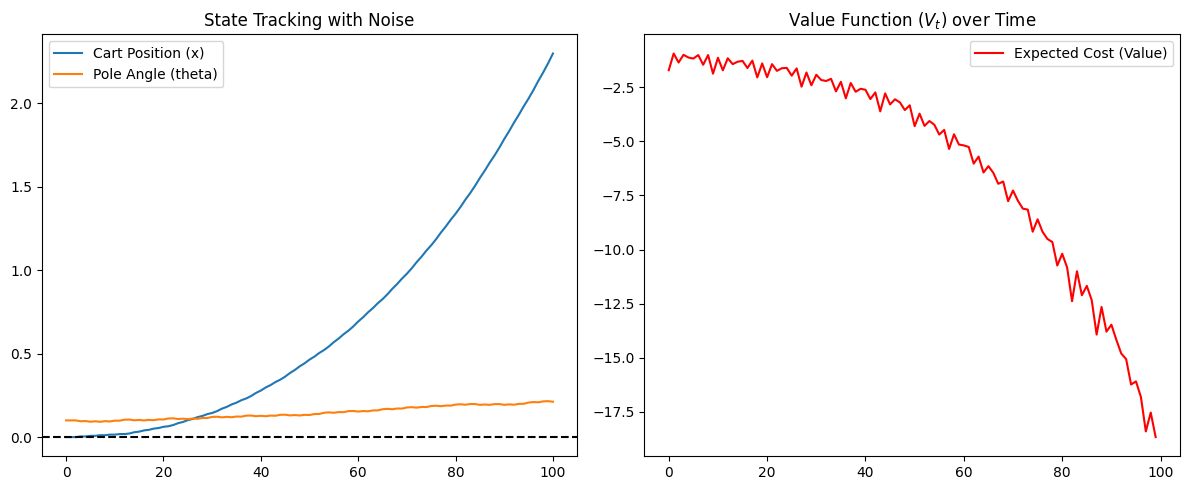

In [76]:
s = np.array([[0], [0], [0.1], [0]]) # 초기 상태 (약간 기울어진 폴)
state_history = [s.flatten()]
cost_history = []
time = 100

for t in range(time):
    # Get next action
    q_value, action = agent.getAction(s)

    # Get next state from env
    next_state, reward = agent.env.transition(s, action)

    state_history.append(s.flatten())
    cost_history.append(reward)
    print(f"Step {t} | State: {s.flatten()} | Action: {action} | V: {q_value:.4f}")
    s = next_state

state_history = np.array(state_history)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(state_history[:, 0], label='Cart Position (x)')
plt.plot(state_history[:, 2], label='Pole Angle (theta)')
plt.axhline(0, color='black', linestyle='--')
plt.title('State Tracking with Noise')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cost_history, color='red', label='Expected Cost (Value)')
plt.title('Value Function ($V_t$) over Time')
plt.legend()

plt.tight_layout()
plt.show()

##Linear Quadratic Regulation

- Represent next states as a Linear Equation (state, action) \
$s_{t+1} = As_t+ Ba_t + w_t \quad (A\inℝ^{n×n} \quad B\inℝ^{n×d})$
- (+) Liniarize state selection \
non-linear model $s_{t+1} = f(s_t,a_t)$
→ Linearize
$$
s_{t+1} \approx (\nabla_s f(\bar{s}_t, \bar{a}_t))^T(s_t-\bar{s}_t)
+(\nabla_af(\bar{s}_t, \bar{a}_t))^T(a_t-\bar{a}_t) +  f(\bar{s}_t, \bar{a}_t)\\
\therefore s_{t+1} \approx As_t+ Ba_t + w_t
$$


- Represent Reward Function as a Quadratic Equation → U penalize state, V penalize action \
$R(s,a) = -(s^TUs+ a^TVa) \quad (U\inℝ^{n×n} \quad V\inℝ^{d×d} ) \quad U, V \ge 0$

- Suppose V as Quadratic function: ($\Phi_{t+1} \in ℝ^{nxn} \quad \Psi_{t+1} \in ℝ$  )
$V^*_{t+1}(s_{t+1}) = s^T_{t+1}\Phi_{t+1}s_{t+1}+\Psi_{t+1}$




###How to compute

From the Terminal state, Calculate all state

- Terminal states \
$V_T^*(s_T) = \max_{a_T}R(s_T,a_T) = -s_T^TUs_T$ ,       $\pi_T^*(s_T) = \vec{0}$

1. Our Goal: Find $a_t$ that maximizes $R(s,a)$

    - (+) $ E[X^T M X] = E[X]^T M E[X] + \text{tr}(M \cdot \text{Cov}(X))$

$$
V_t^*(s_t) = \max_{a_t}R(s_t,a_t) + E_{s_{t+1}\sim P_{s_ta_t}}[V^*_{t+1}(s_{t+1})] \\
= \max_{a_t}-(s^T_tUs_t+ a^T_tVa_t) + E_{s_{t+1}\sim N(As_t+Ba_t,\epsilon_w)}[s_{t+1}^T\Phi_{t+1}s_{t+1}+\Psi_{t+1}
] \\
= \max_{a_t}-(s^T_tUs_t+ a^T_tVa_t) + (As_t + Ba_t)^T \Phi_{t+1} (As_t + Ba_t) + \text{tr}(\Phi_{t+1} \Sigma_w) + \Psi_{t+1}
$$

2. Take derivatives wrt $a_t $ set to 0, solve for $a_t$

$$a_t = (B^T\Phi_{t+1}B-V)^{-1}B^T\Phi_{t+1}A\cdot s_t = L_ts_t$$

3. Constant term

$$ \Psi_t = -\text{tr}(\Phi_{t+1} \Sigma_w) + \Psi_{t+1} $$

4. Plug it into $V^*$

$$
\Phi_t = A^T \left[ \Phi_{t+1} - \Phi_{t+1}B(B^T \Phi_{t+1} B - V)^{-1} B^T \Phi_{t+1} \right] A - U
$$

**Conclusion**
1. Set U, V
1. Calculate A, B for $s_{t+1}$
1. Start with Terminal state +) $\Phi_T = -U \quad \Psi_T = 0$
1. calculate downward: $L_t$(Eqn. 2), $\Psi_t$(Eqn. 3) $\Phi_t$(Eqn. 4)

-> get $a_t$ for all t


In [48]:
def linearizeStatemodel():
    M, m, l, g = 1.0, 0.1, 0.5, 9.8
    dt = 0.02

    A_temp = np.array([
        [0, 1, 0, 0],
        [0, 0, m * g / M, 0],
        [0, 0, 0, 1],
        [0, 0, (M + m) * g / (M * l), 0]
    ])
    B_temp = np.array([[0], [1/M], [0], [1/(M * l)]])

    # Discrete time system
    A = np.identity(4) + A_temp * dt
    B = B_temp * dt
    return A, B

T = 500

# Setting Quadratic form
A, B = linearizeStatemodel()
U = np.diag([-1, -1, -10, -100])
V = np.array([0.01])

# noise w_t
w_std = 0.1
Sigma_w = np.eye(4) * (w_std**2)

# Terminal Condition
phi = [np.zeros((4, 4)) for _ in range(T + 1)]
psi = [0.0 for _ in range(T + 1)]
L_array = [np.zeros((1, 4)) for _ in range(T)]

phi[T] = -U
psi[T] = 0
L_array = []


for t in range(T - 1, -1, -1):
    # L_t = (R + B.T @ Phi @ B)^-1 @ B.T @ Phi @ A
    temp_inv = np.linalg.inv(B.T @ phi[t+1] @ B - V)
    L_t = temp_inv @ B.T @ phi[t+1] @ A
    L_array.append(L_t)

    # constant term
    psi[t] = -np.trace(phi[t+1] @ Sigma_w) + psi[t+1]

    # Riccati equation
    phi[t] = A.T @ (phi[t+1] - phi[t+1] @ B @ temp_inv @ B.T @ phi[t+1]) - U

L_array.reverse()


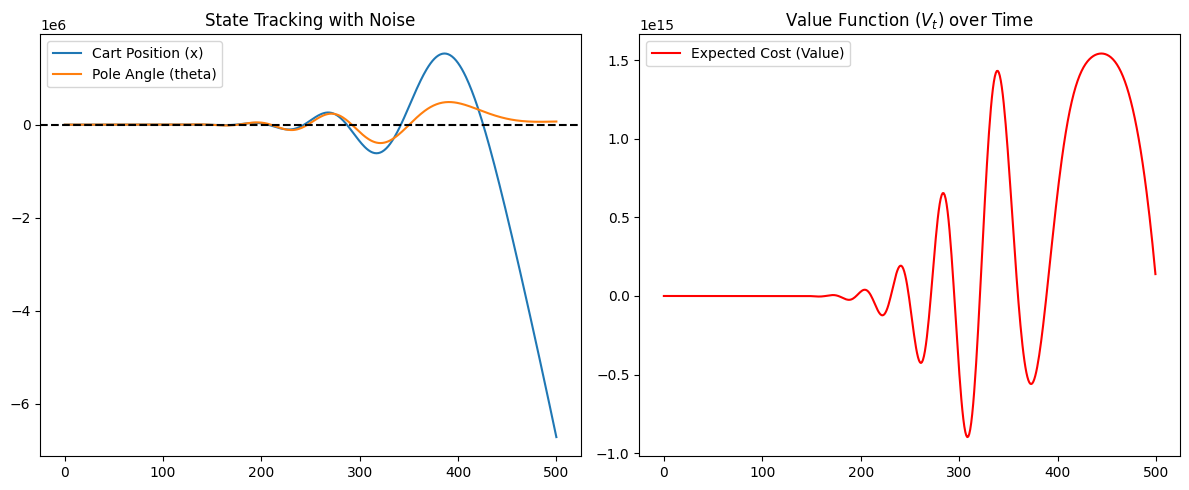

In [49]:
s = np.array([[0], [0], [0.1], [0]]) # 초기 상태 (약간 기울어진 폴)
states = [s]
state_history = [s.flatten()]
cost_history = []

for t in range(T):
    # 최적 제어 입력 a_t = -L_t * s_t
    a = -L_array[t] @ s

    # 현재 시점의 기대 비용(Value) 계산: V_t = s^T * Phi * s + Psi
    v_t = s.T @ phi[t] @ s + psi[t]
    cost_history.append(v_t.item())

    # 시스템 업데이트 (노이즈 추가)
    w = np.random.multivariate_normal(np.zeros(4), Sigma_w).reshape(-1,1)
    s = A @ s + B @ a + w

    state_history.append(s.flatten())

state_history = np.array(state_history)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(state_history[:, 0], label='Cart Position (x)')
plt.plot(state_history[:, 2], label='Pole Angle (theta)')
plt.axhline(0, color='black', linestyle='--')
plt.title('State Tracking with Noise')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cost_history, color='red', label='Expected Cost (Value)')
plt.title('Value Function ($V_t$) over Time')
plt.legend()

plt.tight_layout()
plt.show()